### - Feature Extraction

There's another pipeline is built to collect all audio file data at a time for model training purposes

In [6]:
%time


all_wave = []
all_label = []
for label in labels:
  print(label)
  waves = [f for f in os.listdir(audio_path+label) if f.endswith('.wav')]#creating list of waves contains only .wav files
  b = round(len(waves)*0.25)# slicing size of data
  for wav in waves[:b]:
      samples, sample_rate = librosa.load(audio_path + label + '/'+wav, sr=8000)#compress the frequency 16kHz down to 8000Hz
      if(len(samples)== 8000) :
        all_wave.append(samples)
        all_label.append(label)

Wall time: 0 ns
yes
no


To extract features from audio files, samples and sample_rate are the top 2 features are used for speech recognition project.

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [9]:
import tensorflow.keras
from keras.utils import np_utils

Using TensorFlow backend.


In [10]:
y=np_utils.to_categorical(y, num_classes=len(labels))#make y as dummie variables

The target variable is 'y'. After extracting features from audio files, the audio label is also collected and got transform into numerical data of '1' and '0'.

In [11]:
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

'all_wave' is the X variables.

In [12]:
all_wave = np.array(all_wave).reshape(-1,8000,1)#reshape features to 1 dimensional dataset

X and y are splitted into 3 datasets: training, validating and testing.

In [13]:
from sklearn.model_selection import train_test_split
#80% of trainng size
X_train, X_val, y_train, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=1,shuffle=True)
print('Train: ',X_train.shape,y_train.shape)

Train:  (1424, 8000, 1) (1424, 2)


The training dataset consist 80% of the actual one, that is equivilent to 1424 audio samples.

In [14]:
#20% of testing and validating data - 10% each
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val,test_size = 0.5,random_state=1,shuffle=True) # 20% for each testing and validating size
print('Validation: ',X_val.shape,y_val.shape)
print('Test: ',X_test.shape,y_test.shape)

Validation:  (178, 8000, 1) (178, 2)
Test:  (179, 8000, 1) (179, 2)


The 20% of dataset are splitted equally for the testing and validating datasets, each contains 10% of dataset size that equals to 178 audio files in validating dataset and 179 audio files in testing dataset

# III. Modelling

Model Architect - CNN (Convolutional Neural Network)

In [15]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Conv2D, Input, MaxPooling1D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
K.clear_session()

In [16]:
inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

In [17]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [18]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [19]:
history=model.fit(X_train, y_train ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(X_val,y_val))

Train on 1424 samples, validate on 178 samples
Epoch 1/10
1424/1424 [==============================] - 159s 111ms/sample - loss: 0.6817 - accuracy: 0.5772 - val_loss: 0.6655 - val_accuracy: 0.6629
Epoch 2/10
1424/1424 [==============================] - 149s 104ms/sample - loss: 0.6420 - accuracy: 0.6369 - val_loss: 0.6348 - val_accuracy: 0.6573
Epoch 3/10
1424/1424 [==============================] - 116s 82ms/sample - loss: 0.5756 - accuracy: 0.7001 - val_loss: 0.5572 - val_accuracy: 0.7528
Epoch 4/10
1424/1424 [==============================] - 125s 88ms/sample - loss: 0.5062 - accuracy: 0.7753 - val_loss: 0.4804 - val_accuracy: 0.8034
Epoch 5/10
1424/1424 [==============================] - 141s 99ms/sample - loss: 0.4496 - accuracy: 0.8083 - val_loss: 0.4268 - val_accuracy: 0.8539
Epoch 6/10
1424/1424 [==============================] - 117s 82ms/sample - loss: 0.4230 - accuracy: 0.8237 - val_loss: 0.4521 - val_accuracy: 0.7640
Epoch 7/10
1424/1424 [==============================] - 1

The model accuracy score of training dataset has increased significantly from 0.5 to 0.89. Furthermore, the validating accuracy score is slightly less than the training one around 2%.

### Evaluating Model

Training model

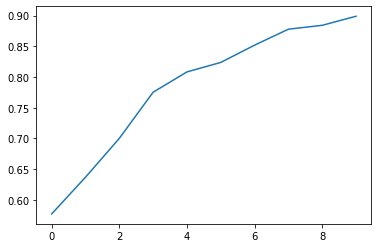

In [21]:
plt.plot(history.history['accuracy'])
plt.show()

Validating model

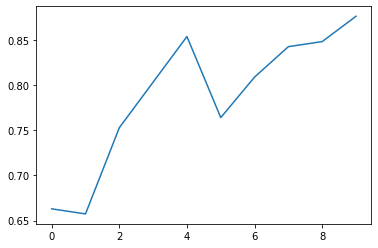

In [22]:
plt.plot(history.history['val_accuracy'])
plt.show()

Visualising Cost

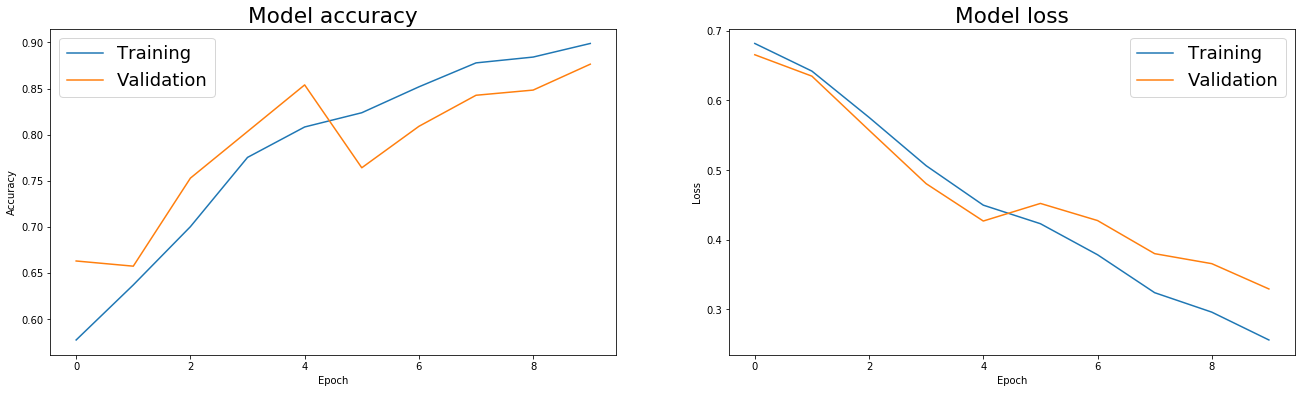

In [23]:
# insert code here
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

plt.rcParams.update({'font.size': 18})

# Plot training & validation accuracy values
ax[0].plot(model.history.history['accuracy'], label = 'Training')
ax[0].plot(model.history.history['val_accuracy'], label = 'Validation')
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend()

# Plot training & validation loss values
ax[1].plot(model.history.history['loss'], label = 'Training')
ax[1].plot(model.history.history['val_loss'], label = 'Validation')
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend()

plt.show()

## Create predictions and evaluate

In [25]:
# Use the model to make predictions from our validation data
%%time
predictions = model.predict(X_test)

Wall time: 4.37 s


In [62]:
print('accuracy_score: ', accuracy_score(y_test, predictions.round()))
print('roc_score: ', roc_auc_score(y_test, predictions.round()))

accuracy_score:  0.9050279329608939
roc_score:  0.9038848378174502


Confusion Matrix

In [66]:
def print_cm(cm):
    d_size = max(len('%d' % cm.max()), len('%d' % cm.shape[1]))
    if min(cm.shape) > 10: # make sparse
        print('Sparse Matrix (*=diagonal)')
        fmt_c = ', c%%0%dd%%s= %%%dd' % (d_size, d_size)
        for i in range(cm.shape[0]):
            s = fmt_r % i
            for j in range(cm.shape[1]):
                if cm[i, j] > 0:
                    s += fmt_c % (j, '*' if i == j else ' ', cm[i, j])
            print(s)
    else: # make dense
        c = '%%%dd ' % d_size
        s = '%s| ' % (' ' * d_size)
        s += ''.join([c % i for i in range(len(cm[0]))])
        print(s)
        print('-' * len(s))
        for i, r in enumerate(cm):
            s = '%%%dd| ' % d_size
            s = s % i
            s += c * len(r)
            print(s % tuple(r))

In [67]:
y_test_target = np.array([x.argmax() for x in y_test])
predictions_test_target = np.array([x.argmax() for x in predictions.round()])
cm = confusion_matrix(y_test_target, predictions_test_target)
%matplotlib inlineprint_cm(cm)

  |  0  1 
----------
 0| 89  8 
 1|  9 73 


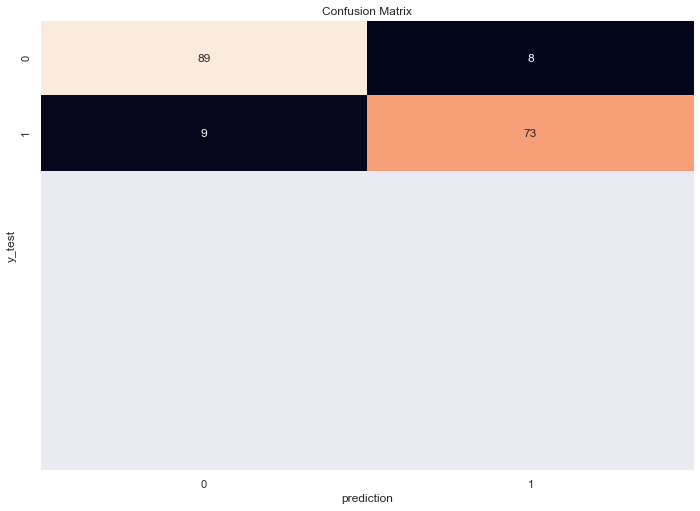

In [80]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(cm,annot=True,cbar=False)
ax.set_ylim(6.0, 0)
plt.ylabel('y_test')
plt.xlabel('prediction')
plt.title('Confusion Matrix')
plt.show()

### ROC curve

In [83]:
fpr, tpr, thr = roc_curve(y_test_target, predictions_test_target)
roc_auc = auc(fpr, tpr)

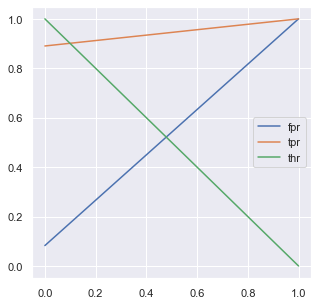

In [84]:
plt.figure(figsize=(5, 5))
plt.plot(range(len(thr)-1), fpr[1:], label='fpr')
plt.plot(range(len(thr)-1), tpr[1:], label='tpr')
plt.plot(range(len(thr)-1), thr[1:], label='thr')
plt.legend()
plt.show()

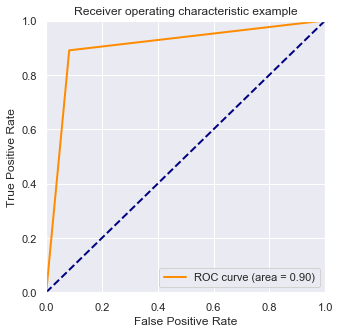

In [85]:
# Plot the ROC Curve
plt.figure(figsize=(5, 5))
lw = 2
plt.plot(fpr,
         tpr,
         color='darkorange',
         lw=lw,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1],
         [0, 1],
         color='navy',
         lw=lw,
         linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc='lower right')
plt.show()

# IV. Saving and Deploying Model

##### Convert to TF Lite

In [87]:
import tensorflow as tf

In [88]:
# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# Save the model to disk
open("model.tflite", "wb").write(tflite_model)

1619496

##### Write to C file (required to be run on as adminnistration)

In [96]:
# Install xxd if it is not available
apt-get -qq install xxd
# Save the file as a C source file
xxd -i model.tflite > model.cc
# Print the source file
#!cat sine_model_quantized.cc